In [49]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [51]:
all_data_file = os.path.join(os.getcwd(), 'all_data.csv')
all_data = pd.read_csv(all_data_file)

In [54]:
# drop rows where activity is "miscMovement breathingNormal"
all_data = all_data[all_data['activity'] != 'miscMovement breathingNormal']
all_data[['main_activity', 'sub_activity']] = all_data['activity'].str.split(' ', expand=True)

In [56]:
random_seed = 42
n_time_steps = 50
n_features = 6
step = 10
n_epochs = 50
batch_size = 64
learning_rate = 0.0015
l2_loss = 0.0015

In [57]:
segments_main = []
labels_main = []

for i in range(0, len(all_data) - n_time_steps, step):
    window_data = all_data[i: i + n_time_steps]
    segments_main.append(window_data.drop(['activity', 'main_activity', 'sub_activity'], axis=1).values)
    labels_main.append(window_data['main_activity'].values[0])

segments_main = np.asarray(segments_main, dtype=np.float32).reshape(-1, n_time_steps, n_features)
labels_main = np.asarray(labels_main)

In [58]:
le_main = LabelEncoder()
labels_main = le_main.fit_transform(labels_main)

In [59]:
x_main_train, x_main_test, y_main_train, y_main_test = train_test_split(segments_main, labels_main, test_size=0.2, random_state=random_seed)

In [60]:
x_main_train.shape, y_main_train.shape, x_main_test.shape, y_main_test.shape

((183574, 50, 6), (183574,), (45894, 50, 6), (45894,))

In [61]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D
from keras.optimizers.legacy import Adam

In [62]:
conv_x_main_train = x_main_train.reshape(-1, n_time_steps, n_features, 1)
conv_x_main_test = x_main_test.reshape(-1, n_time_steps, n_features, 1)

conv_x_main_train.shape, conv_x_main_test.shape

((183574, 50, 6, 1), (45894, 50, 6, 1))

In [63]:
main_activity_model = Sequential()
main_activity_model.add(Conv2D(16, (2, 2), activation ='relu', input_shape = conv_x_main_train[0].shape))
main_activity_model.add(Dropout(0.1))

main_activity_model.add(Conv2D(32, (2, 2), activation='relu'))
main_activity_model.add(Dropout(0.2))

main_activity_model.add(Flatten())

main_activity_model.add(Dense(64, activation ='relu'))
main_activity_model.add(Dropout(0.5))

main_activity_model.add(Dense(44, activation='softmax'))

In [64]:
main_activity_model.compile(
    optimizer=Adam(learning_rate = 0.0015), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy']
)

history = main_activity_model.fit(
    conv_x_main_train, y_main_train, epochs =5, validation_data= (conv_x_main_test, y_main_test), verbose=1
)

Epoch 1/5
5737/5737 [==============================] - 27s 5ms/step - loss: 0.6093 - accuracy: 0.7567 - val_loss: 0.4337 - val_accuracy: 0.8143
Epoch 2/5
5737/5737 [==============================] - 28s 5ms/step - loss: 0.4708 - accuracy: 0.8000 - val_loss: 0.3949 - val_accuracy: 0.8318
Epoch 3/5
5737/5737 [==============================] - 26s 5ms/step - loss: 0.4316 - accuracy: 0.8155 - val_loss: 0.3725 - val_accuracy: 0.8344
Epoch 4/5
5737/5737 [==============================] - 28s 5ms/step - loss: 0.4098 - accuracy: 0.8221 - val_loss: 0.3639 - val_accuracy: 0.8437
Epoch 5/5
5737/5737 [==============================] - 30s 5ms/step - loss: 0.4002 - accuracy: 0.8268 - val_loss: 0.3525 - val_accuracy: 0.8442


In [28]:
loss, accuracy = main_activity_model.evaluate(conv_x_main_test, y_main_test)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

1468/1468 [==============================] - 2s 1ms/step - loss: 0.3785 - accuracy: 0.8396
Test loss: 0.37845855951309204, Test accuracy: 0.8395732045173645


In [40]:
# check and print confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [41]:
# predict the test set results
y_pred = main_activity_model.predict(conv_x_main_test)

1468/1468 [==============================] - 2s 1ms/step


In [42]:
# convert predictions classes to one hot vectors
y_pred_classes = np.argmax(y_pred, axis = 1)

In [44]:
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_main_test, y_pred_classes)

In [46]:
# plot the confusion matrix with names of the main activities in main_activity_labels
main_activity_labels = le_main.classes_

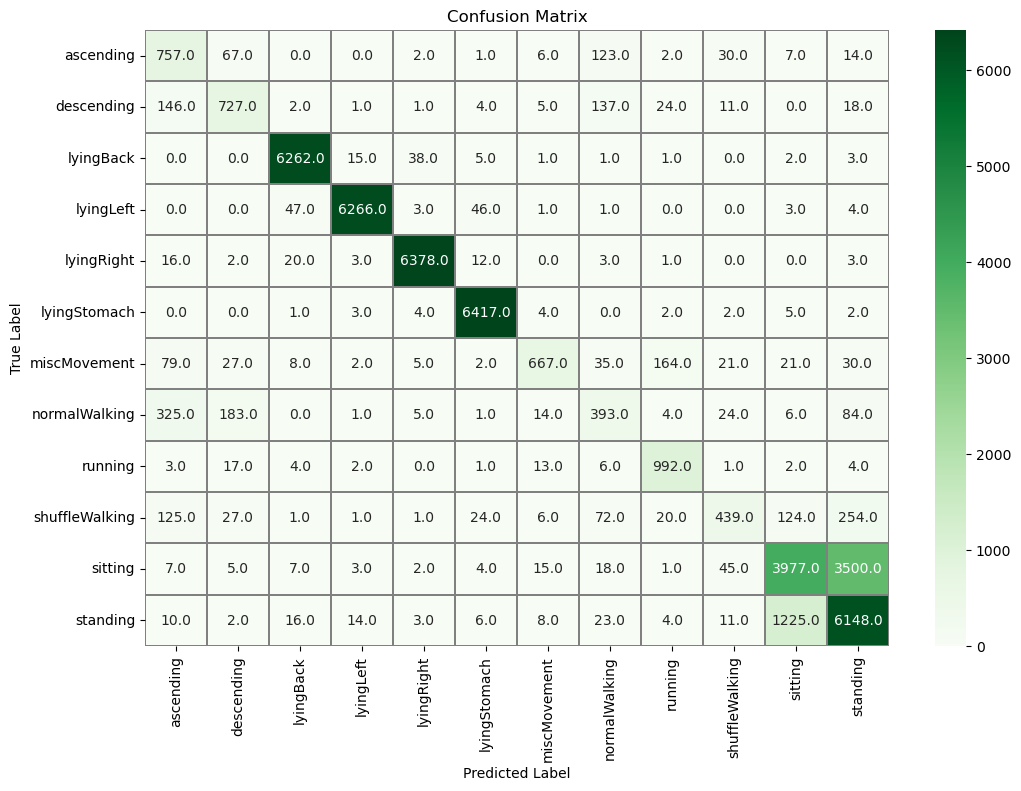

In [47]:
# plot the confusion matrix
f, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01, cmap="Greens", linecolor="gray", fmt= '.1f', ax=ax, xticklabels=main_activity_labels , yticklabels=main_activity_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()